In [ ]:
!pip install plotly

In [2]:
import time
import os
import shutil
from itertools import islice
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from pyspark.sql import functions as F
from pyspark.sql import SparkSession
from pyspark.sql.types import *
import findspark
findspark.init()

from google.cloud import storage

spark = SparkSession.builder \
    .config("spark.executor.memory", "8g") \
    .config("spark.driver.memory", "16g") \
    .config("spark.executor.cores", "4") \
    .config("spark.driver.maxResultSize", "16g") \
    .config("spark.dynamicAllocation.enabled", "true") \
    .config("spark.dynamicAllocation.minExecutors", "4") \
    .config("spark.dynamicAllocation.maxExecutors", "100") \
    .getOrCreate()



spark.conf.set("spark.sql.repl.eagerEval.enabled",True)
spark.conf.set("spark.sql.repl.eagerEval.maxCharsPerCell", 200)

print(spark.version)

3.1.3


## Re-read from save

In [15]:
read_bucket = "gs://msca-bdp-students-bucket/shared_data/xiuan/commits_sampled.parquet"
result = spark.read.parquet(read_bucket)

# Filter out rows where "message" or "subject" is an empty string
sampling_result = result.filter(
    (F.col("message") != "") & (F.col("subject") != "")
)

# Verify the results
sampling_result.show(1, truncate=False)

+------------------------------+-----------------------------------+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|repo_name_exploded            |subject                            |message                                                                                                                                                                                                                                                                                                                                                     |
+------------------------------+-----------------------------------+------------------------------------------------------------------------------------------------

In [16]:
%time languages_spDf = spark.read.parquet("gs://msca-bdp-data-open/final_project_git/languages")

CPU times: user 3.5 ms, sys: 0 ns, total: 3.5 ms
Wall time: 354 ms


In [17]:
top_languages = ['Shell', 'Python', 'C', 'C++', 'Perl']

In [18]:
languages_repo = languages_spDf.join(
    sampling_result,
    languages_spDf["repo_name"] == sampling_result["repo_name_exploded"],
    how="inner"
)
languages_repo.printSchema()                          

root
 |-- repo_name: string (nullable = true)
 |-- language: array (nullable = true)
 |    |-- element: struct (containsNull = true)
 |    |    |-- name: string (nullable = true)
 |    |    |-- bytes: long (nullable = true)
 |-- repo_name_exploded: string (nullable = true)
 |-- subject: string (nullable = true)
 |-- message: string (nullable = true)



In [22]:
from pyspark.sql.functions import col, explode, expr, from_unixtime

language_repo_name = languages_repo.select(col('repo_name_exploded'),
                                           col('subject'),
                                           col('message'),
                     explode('language').alias("language_detail")
                     ).select(col("repo_name_exploded"),
                              col("language_detail.name").alias("language_name"),
                              col('subject'),
                              col('message')
).filter(col("language_name").isin(top_languages))


In [23]:
sampling_result = language_repo_name

In [24]:
rows = sampling_result.count()
print(f"Sampled table contains {rows} rows")
sampling_result.limit(5)

Sampled table contains 139089 rows


repo_name_exploded,language_name,subject,message
jlz27/kubernetes,C,Move hostip to sy...,Move hostip to sy...
jlz27/kubernetes,Python,Move hostip to sy...,Move hostip to sy...
jlz27/kubernetes,Shell,Move hostip to sy...,Move hostip to sy...
jlz27/kubernetes,C,Fix etcd unavaila...,Fix etcd unavaila...
jlz27/kubernetes,Python,Fix etcd unavaila...,Fix etcd unavaila...


In [27]:
# Import minHash and other pyspark.ml.feaature
from pyspark.ml.feature import MinHashLSH
from pyspark.ml.feature import CountVectorizer, IDF, CountVectorizerModel, Tokenizer, RegexTokenizer, StopWordsRemover
from pyspark.ml.feature import SparkContext
from pyspark.sql import SQLContext, Row
from pyspark.sql import functions as F
from pyspark.sql.functions import col
from pyspark.ml.feature import RegexTokenizer, StopWordsRemover
import pyspark.sql.functions as F

In [36]:
def compute_near_duplicates_for_language(language, sampling_result, jaccard_threshold):
    # Filter sampling_result for the given language
    filtered_result = sampling_result.filter(F.col("language_name") == language)

    # Add an ID column
    filtered_result = filtered_result.withColumn("id", F.monotonically_increasing_id())

    # Clean with only alphabet and number
    filtered_result = filtered_result.withColumn(
        "clean_message", F.regexp_replace(F.col("message"), "[^a-zA-Z0-9\\s]", "")
    ).withColumn(
        "clean_subject", F.regexp_replace(F.col("subject"), "[^a-zA-Z0-9\\s]", "")
    )

    # Tokenize the text and title
    message_tokenizer = RegexTokenizer(inputCol="clean_message", outputCol="message_tokens", pattern="\\W")
    filtered_result = message_tokenizer.transform(filtered_result)

    subject_tokenizer = RegexTokenizer(inputCol="clean_subject", outputCol="subject_tokens", pattern="\\W")
    filtered_result = subject_tokenizer.transform(filtered_result)

    # Remove stopwords
    message_remover = StopWordsRemover(inputCol="message_tokens", outputCol="filtered_message")
    filtered_result = message_remover.transform(filtered_result)

    subject_remover = StopWordsRemover(inputCol="subject_tokens", outputCol="filtered_subject")
    filtered_result = subject_remover.transform(filtered_result)

    # Filter out rows with < 5 tokens
    filtered_result = filtered_result.filter(F.size(F.col('filtered_message')) > 10)
    filtered_result = filtered_result.filter(F.size(F.col('filtered_subject')) > 5)

    # Vectorize the text
    text_vectorizer = CountVectorizer(inputCol="filtered_message", outputCol="message_features", minDF=1.0)
    text_model = text_vectorizer.fit(filtered_result)
    filtered_result = text_model.transform(filtered_result)

    # Vectorize the title
    title_vectorizer = CountVectorizer(inputCol="filtered_subject", outputCol="subject_features", minDF=1.0)
    title_model = title_vectorizer.fit(filtered_result)
    filtered_result = title_model.transform(filtered_result)

    # MinHashLSH for text
    text_mh = MinHashLSH(inputCol="message_features", outputCol="message_hash", numHashTables=10)
    text_model = text_mh.fit(filtered_result)
    text_hashed = text_model.transform(filtered_result)

    # MinHashLSH for title
    title_mh = MinHashLSH(inputCol="subject_features", outputCol="subject_hash", numHashTables=10)
    title_model = title_mh.fit(filtered_result)
    title_hashed = title_model.transform(filtered_result)

    # Ensure required columns are retained
    text_hashed = text_hashed.select("id", "message", "message_features", "message_hash")
    title_hashed = title_hashed.select("id", "subject", "subject_features", "subject_hash")

    # Find near-duplicates for text
    text_dups = text_model.approxSimilarityJoin(text_hashed, text_hashed, jaccard_threshold) \
        .filter("datasetA.id < datasetB.id") \
        .select(
            F.col("datasetA.id").alias("id_A"),
            F.col("datasetB.id").alias("id_B"),
            F.col("datasetA.message").alias("message_A"),
            F.col("datasetB.message").alias("message_B"),
            F.col("distCol")
        )

    # Find near-duplicates for title
    title_dups = title_model.approxSimilarityJoin(title_hashed, title_hashed, jaccard_threshold) \
        .filter("datasetA.id < datasetB.id") \
        .select(
            F.col("datasetA.id").alias("id_A"),
            F.col("datasetB.id").alias("id_B"),
            F.col("datasetA.subject").alias("subject_A"),
            F.col("datasetB.subject").alias("subject_B"),
            F.col("distCol")
        )

    return text_dups, title_dups


In [37]:
# Process each language in the top_languages list
results = {}
for language in top_languages:
    print(f"Processing language: {language}")
    text_dups, title_dups = compute_near_duplicates_for_language(language, sampling_result,0.2)
    results[language] = {"text_dups": text_dups, "title_dups": title_dups}

Processing language: Shell


Processing language: Python


Processing language: C


Processing language: C++


Processing language: Perl


In [ ]:
# Show example result for python
language_to_inspect = "Python"
results[language_to_inspect]["text_dups"].show(5, truncate=False)
results[language_to_inspect]["title_dups"].show(5, truncate=False)

24/12/13 23:41:37 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 1205.2 KiB
24/12/13 23:41:37 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 1204.2 KiB
24/12/13 23:41:56 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 1249.7 KiB
24/12/13 23:44:04 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 1178.7 KiB


+------------+------------+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

+------------+------------+-------------------------------------------------------------------+-------------------------------------------------------------------+-------+
|id_A        |id_B        |subject_A                                                          |subject_B                                                          |distCol|
+------------+------------+-------------------------------------------------------------------+-------------------------------------------------------------------+-------+
|103079226192|103079231854|flex_array: add helpers to get and put to make pointers easy to use|flex_array: add helpers to get and put to make pointers easy to use|0.0    |
|103079223770|103079230778|staging: vme: Simplfy string usage in vme_user_probe()             |staging: vme: Simplfy string usage in vme_user_probe()             |0.0    |
|103079221884|103079234006|[POWERPC] Small cleanups to the cuboot bootwrapper code            |[POWERPC] Small cleanups to the cuboot bootwr

Processing language: Shell


24/12/13 23:45:52 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 1234.8 KiB
24/12/13 23:45:53 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 1233.8 KiB
24/12/13 23:46:11 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 1279.3 KiB
24/12/13 23:47:54 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 1207.9 KiB


Processing language: Python


24/12/13 23:49:28 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 1205.2 KiB
24/12/13 23:49:28 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 1204.2 KiB
24/12/13 23:49:47 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 1249.7 KiB
24/12/13 23:51:34 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 1178.3 KiB


Processing language: C


24/12/13 23:53:11 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 1191.6 KiB
24/12/13 23:53:12 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 1190.6 KiB
24/12/13 23:53:30 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 1236.1 KiB
24/12/13 23:55:31 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 1164.7 KiB


Processing language: C++


24/12/13 23:57:02 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 1189.1 KiB
24/12/13 23:57:02 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 1188.0 KiB
24/12/13 23:57:21 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 1233.6 KiB
24/12/13 23:59:21 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 1162.1 KiB


Processing language: Perl


24/12/14 00:00:58 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 1169.3 KiB
24/12/14 00:00:58 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 1168.3 KiB
24/12/14 00:01:15 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 1213.8 KiB
24/12/14 00:03:17 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 1142.4 KiB


  Language  Total Commits  Near-Duplicates Message  Near-Duplicates Subject  \
0    Shell          32412                      358                      278   
1   Python          28804                      356                      275   
2        C          26546                      356                      277   
3      C++          26072                      356                      276   
4     Perl          25255                      356                      276   

   Near-Duplicates Both  
0                   268  
1                   267  
2                   267  
3                   267  
4                   267  


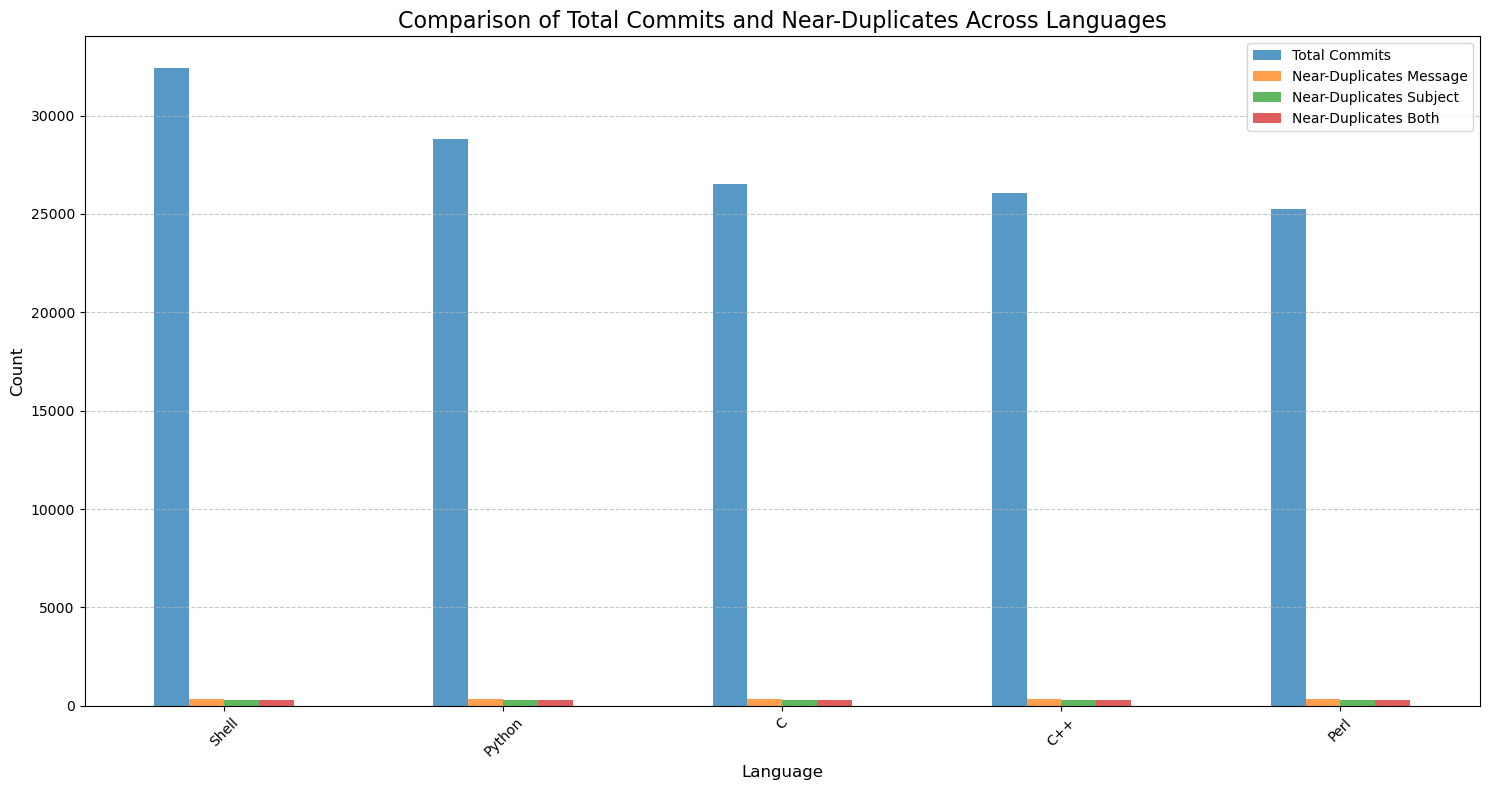

In [39]:
import matplotlib.pyplot as plt
import seaborn as sns

# Initialize an empty list to store the data for Pandas DataFrame
data = []

# Process each language
for language in top_languages:
    print(f"Processing language: {language}")
    
    # Total commits for the language
    total_commits = sampling_result.filter(F.col("language_name") == language).count()
    
    # Convert Spark DataFrames to Pandas
    text_dups_pd = results[language]["text_dups"].toPandas()
    title_dups_pd = results[language]["title_dups"].toPandas()
    
    # Near-duplicates counts
    near_duplicates_message = len(text_dups_pd)
    near_duplicates_subject = len(title_dups_pd)
    
    # Count of rows that are near-duplicates in both (inner join in Pandas)
    near_duplicates_both = pd.merge(
        text_dups_pd[['id_A', 'id_B']],
        title_dups_pd[['id_A', 'id_B']],
        on=['id_A', 'id_B']
    ).shape[0]
    
    # Append the results to the list
    data.append({
        "Language": language,
        "Total Commits": total_commits,
        "Near-Duplicates Message": near_duplicates_message,
        "Near-Duplicates Subject": near_duplicates_subject,
        "Near-Duplicates Both": near_duplicates_both
    })

# Convert to Pandas DataFrame
df_results = pd.DataFrame(data)

# Display the DataFrame
print(df_results)

# Plot the results
df_results.set_index("Language").plot(kind="bar", figsize=(15, 8), alpha=0.75)

# Add title and labels
plt.title("Comparison of Total Commits and Near-Duplicates Across Languages", fontsize=16)
plt.xlabel("Language", fontsize=12)
plt.ylabel("Count", fontsize=12)
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Show the plot
plt.tight_layout()
plt.show()


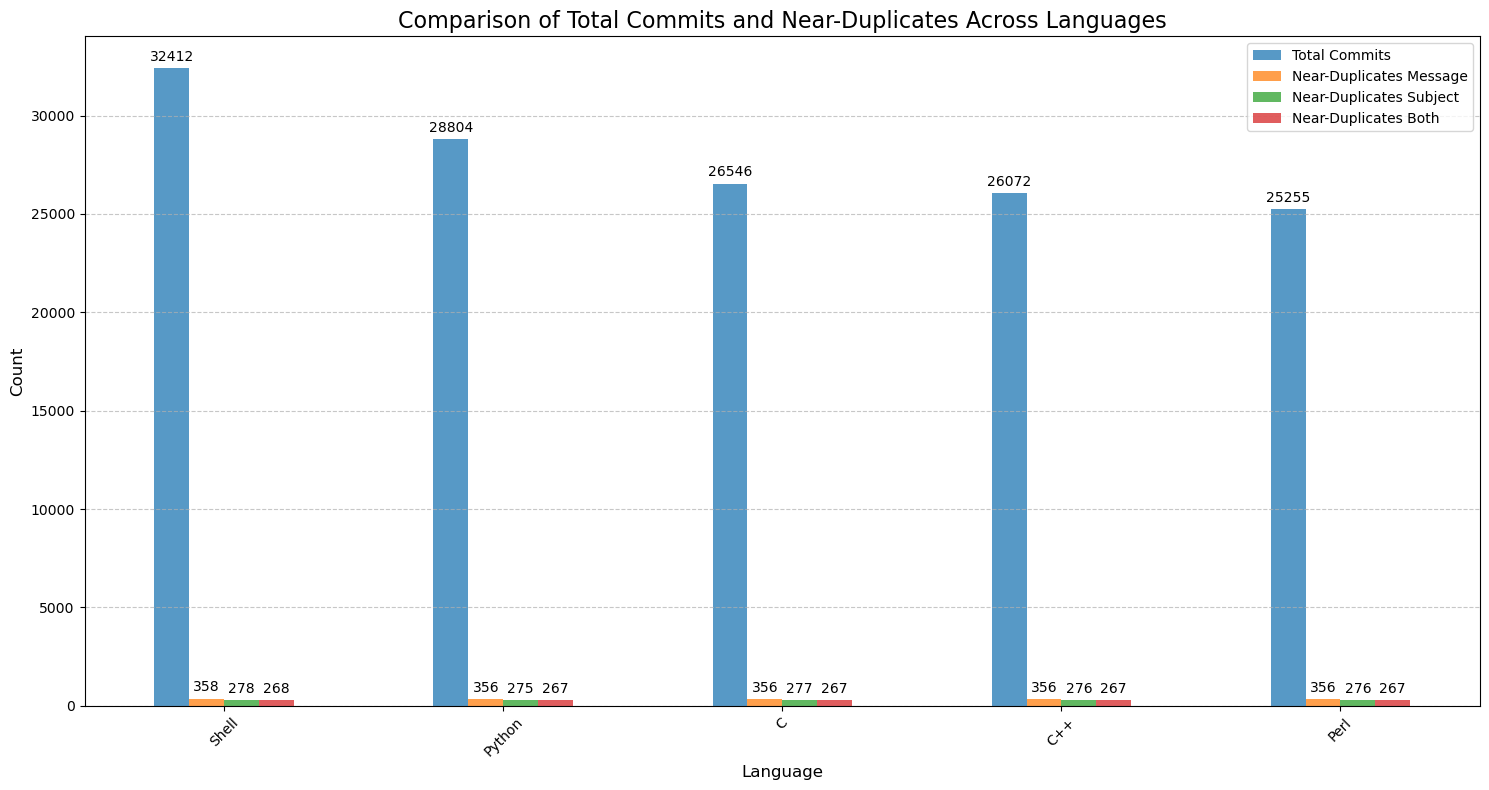

In [40]:
# Plot the bar chart
ax = df_results.set_index("Language").plot(kind="bar", figsize=(15, 8), alpha=0.75)

# Add numbers on each bar
for container in ax.containers:
    ax.bar_label(container, fmt='%d', label_type='edge', fontsize=10, padding=3)

# Add title and labels
plt.title("Comparison of Total Commits and Near-Duplicates Across Languages", fontsize=16)
plt.xlabel("Language", fontsize=12)
plt.ylabel("Count", fontsize=12)
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Show the plot
plt.tight_layout()
plt.show()

In [ ]:
# Plot the bar chart
ax = df_results.set_index("Language").plot(kind="bar", figsize=(15, 8), alpha=0.75)

# Add numbers on each bar
for container in ax.containers:
    ax.bar_label(container, fmt='%d', label_type='edge', fontsize=10, padding=3)

# Add title and labels
plt.title("Comparison of Total Commits and Near-Duplicates Across Languages", fontsize=16)
plt.xlabel("Language", fontsize=12)
plt.ylabel("Count", fontsize=12)
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Show the plot
plt.tight_layout()
plt.show()

# SimHash